In [17]:
from os.path import join
import json
import csv
import glob
import os

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from scipy.stats import t, sem, ttest_rel
from IPython.display import Image
from numpy import array

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)
library(grid)

/home/ben/miniconda3/envs/qiime2-clean/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)


In [4]:
empo3_dir = '/home/ben/Data/empo_3'

In [5]:
columns = ['sample type', 'sample', 'fold']
data = {c:[] for c in columns}
for type_dir in glob.glob(join(empo3_dir, '*')):
    if not os.path.exists(join(type_dir, 'results', 'weights.qza')):
        continue
    type_ = os.path.basename(type_dir)
    if type_ in ('sterile-water-blank', 'single-strain', 'mock-community', 'nick', 'plant-surface'):
        continue
    for fold_dir in glob.glob(join(type_dir, 'tmp', 'fold-*')):
        _, fold = fold_dir.rsplit('-', 1)
        with open(join(fold_dir, 'sample_test.json')) as fh:
            try:
                samples = json.load(fh)
            except UnicodeDecodeError:
                print(join(fold_dir, 'sample_test.json'), 'is corrupted')
        data['sample'].extend(samples)
        data['sample type'].extend([type_]*len(samples))
        data['fold'].extend([fold]*len(samples))
folds = DataFrame(data)

In [6]:
abundances = read_csv(join(empo3_dir, 'abundances.tsv'), sep='\t')
abundances = abundances.set_index(['sample type', 'sample'])

In [7]:
eval_comp = read_csv(join(empo3_dir, 'eval_comp_results.tsv'), sep='\t')
eval_comp = eval_comp.join(abundances, ['sample type', 'sample'])

In [8]:
folds = folds.set_index(['sample type', 'sample'])
eval_comp = eval_comp.join(folds, ['sample type', 'sample'])

In [9]:
level7 = eval_comp[(eval_comp['level'] == 7) | (eval_comp['level'] == 6)]
level7 = level7[(level7['class weights'] == 'average') |
                (level7['class weights'] == 'bespoke70') |
                (level7['class weights'] == 'uniform70')]
level7 = level7[level7['abundance'] >= 1000]

In [10]:
grouped = level7.groupby(['sample type', 'class weights', 'fold', 'level'])
def weighted_stats(x):
    d1 = x['TDR'].mean()
    return Series([d1], index=['mean'])
figure2 = grouped.apply(weighted_stats)
figure2.reset_index(inplace=True)

In [11]:
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline',
    'average', 'uniform70', 'bespoke70']
new_labels = [
    'Other'] * 14 + ['Average', 'Uniform', 'Bespoke']
for old, new in zip(old_labels, new_labels):
    figure2.loc[figure2['class weights'] == old, 'class weights'] = new
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline'
]
new_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
for old, new in zip(old_labels, new_labels):
    figure2.loc[figure2['sample type'] == old, 'sample type'] = new
for old, new in zip((6, 7), ('Genus', 'Species')):
    figure2.loc[figure2['level'] == old, 'level'] = new

In [12]:
colours = ['56B4E9', '009E73', 'E69F00']
alpha = 0.1
for colour in colours:
    faded = ''
    for s in range(0,6,2):
        c = int(colour[s:s+2], 16)
        faded += hex(int(c*alpha + 0xFF*(1-alpha)))[2:]
    print(faded)

eef7fc
e5f5f1
fcf5e5


In [15]:
%%R -i figure2
figure2$sample.type <- factor(figure2$sample.type, levels=c(
 'Water (saline)',
 'Surface (saline)',
 'Sediment (saline)',
 'Water (non-saline)',
 'Surface (non-saline)',
 'Soil (non-saline)',
 'Sediment (non-saline)',
 'Plant rhizosphere',
 'Plant corpus',
 'Animal surface',
 'Animal secretion',
 'Animal proximal gut',
 'Animal distal gut',
 'Animal corpus'))
figure2$class.weights <- factor(figure2$class.weights, levels=c(
    'Uniform', 'Average', 'Bespoke'
))
figure2$fill <- paste(figure2$level, figure2$class.weights)
figure2$fill <- factor(figure2$fill, levels=c(
  'Species Uniform',
  'Species Average',
  'Species Bespoke',
  'Genus Uniform',
  'Genus Average',
  'Genus Bespoke'))
fillPalette <- c("#56B4E9", "#009E73", "#E69F00", "#eef7fc", "#e5f5f1", "#fcf5e5")
ggplot(data=figure2, aes(x=sample.type, y=mean)) +
  geom_boxplot(data=figure2[figure2$level == 'Species',], lwd=0.2, outlier.size=0.2, position=position_dodge(width=0.9),
           aes(fill=fill)) +
  geom_boxplot(data=figure2[figure2$level == 'Genus',], lwd=0.2, outlier.size=0.2, position=position_dodge(width=0.9),
           aes(fill=fill)) +
  coord_flip(clip="off") +
  theme_bw() +
  labs(x='EMPO3 Habitat', y='Taxon Discovery Rate') +
  scale_fill_manual(name='Level & Weights', values=fillPalette) +
  theme(plot.margin = unit(c(1, 1, 2, 1), "lines"),
        axis.text.y = element_text(angle = 45)) +
  annotation_custom(
    grob=grid::textGrob(label = "Better Performance"),
    xmin=-0.5, xmax=-0.5, ymin=0.55, ymax=0.55
  ) + 
  annotation_custom(
    grob=linesGrob(arrow=arrow(type="open", ends="last", length=unit(2,"mm"))), 
    xmin=-0.3, xmax=-0.3, ymin=0.35, ymax=0.75
  )

ggsave(file="tdr-vs-habitat.png", width=5, height=10, dpi=300)

/home/ben/miniconda3/envs/qiime2-clean/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


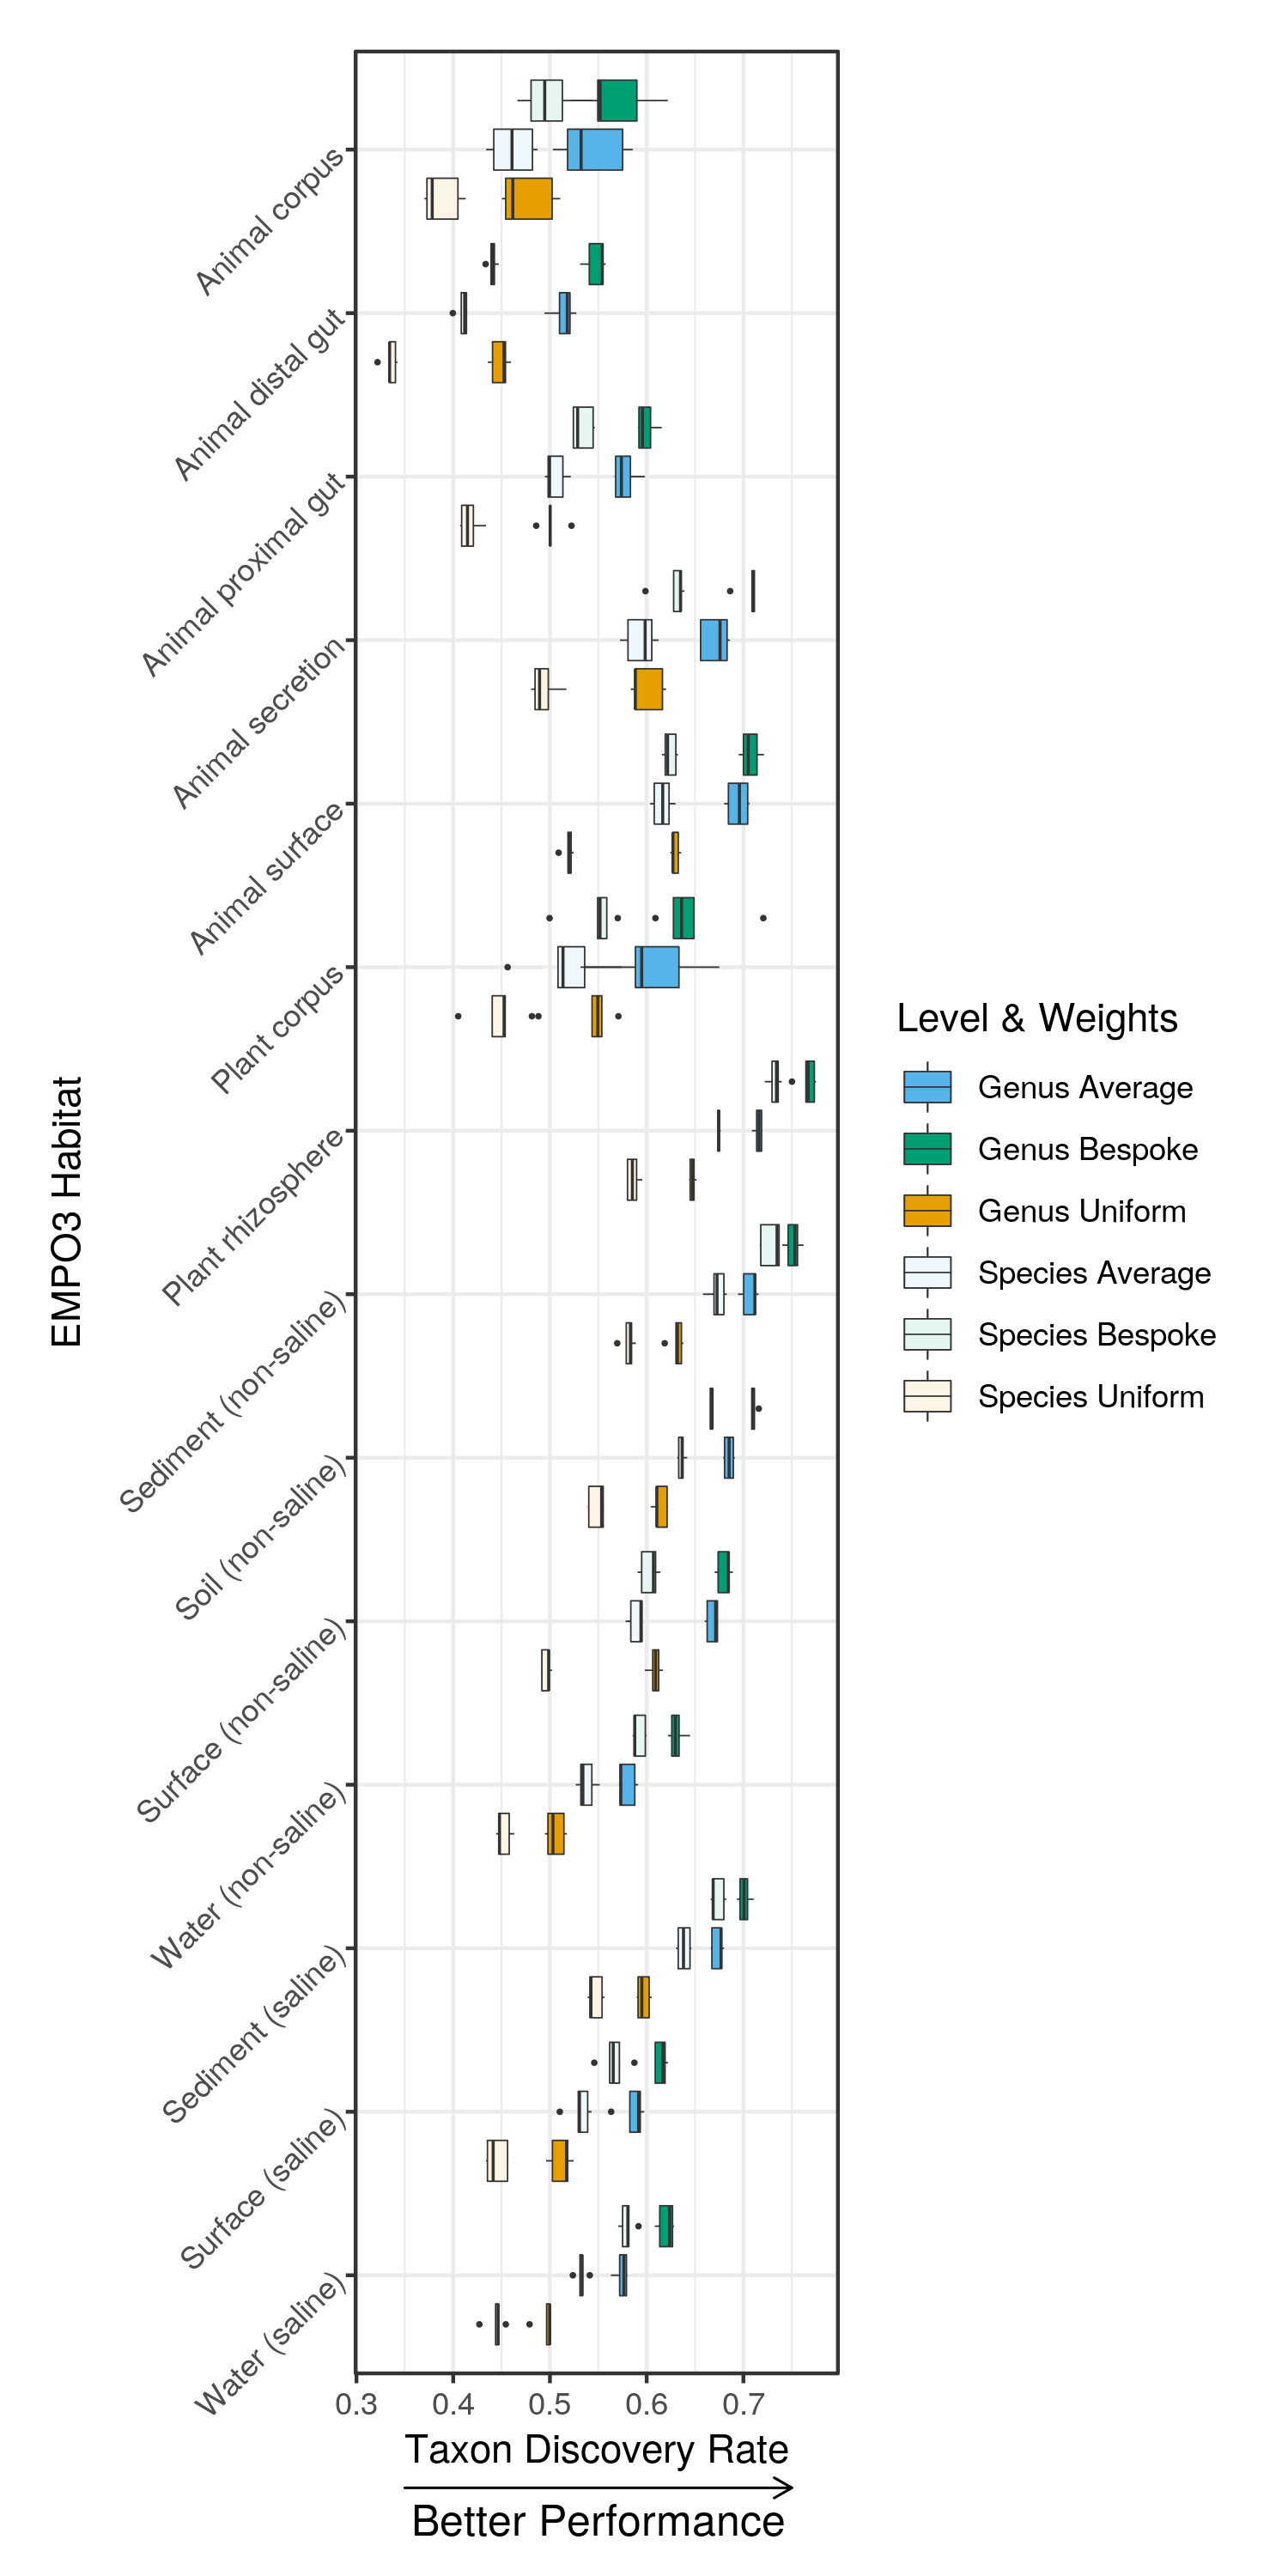

In [16]:
Image("tdr-vs-habitat.png")

In [18]:
grouped = figure2.groupby(['sample type', 'class weights', 'level'])
def weighted_stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    #lower, upper = t.interval(0.95, 5, mu, se)
    lower, upper = mu-se, mu+se
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
figure2 = grouped.apply(weighted_stats)
figure2.reset_index(inplace=True)

level7 = figure2[figure2['level'] == 'Species']

print(ttest_rel(array(level7[level7['class weights'] == 'Bespoke']['mean']), 
          array(level7[level7['class weights'] == 'Uniform']['mean'])))

print(ttest_rel(array(level7[level7['class weights'] == 'Bespoke']['mean']), 
          array(level7[level7['class weights'] == 'Average']['mean'])))

print(ttest_rel(array(level7[level7['class weights'] == 'Average']['mean']), 
          array(level7[level7['class weights'] == 'Uniform']['mean'])))

Ttest_relResult(statistic=29.934543824884845, pvalue=2.2338856983980405e-13)
Ttest_relResult(statistic=9.200033073542361, pvalue=4.69171404266616e-07)
Ttest_relResult(statistic=38.06822146690176, pvalue=1.014875152264317e-14)


In [15]:
max(figure2['upper'] - figure2['lower'])

0.12611350900624274

In [16]:
figure2

,sample type,class weights,mean,lower,upper
0,Animal corpus,Average,0.304970,0.255741,0.354199
1,Animal corpus,Bespoke,0.158679,0.125116,0.192243
2,Animal corpus,Wrong,0.252818,0.189761,0.315874
3,Animal corpus,Uniform,0.295128,0.272128,0.318128
4,Animal distal gut,Average,0.186952,0.180737,0.193166
5,Animal distal gut,Bespoke,0.158793,0.155569,0.162016
6,Animal distal gut,Wrong,0.201032,0.195528,0.206536
7,Animal distal gut,Uniform,0.251436,0.242417,0.260455
8,Animal proximal gut,Average,0.247377,0.224974,0.269781
9,Animal proximal gut,Bespoke,0.188780,0.163140,0.214420


In [17]:
bespoke = figure2[figure2['class weights'] == 'Bespoke']['mean']
print(min(bespoke), max(bespoke))
uniform = figure2[figure2['class weights'] == 'Uniform']['mean']
print(min(uniform), max(uniform))

0.077939392151066 0.1887800108306231
0.1238677996316758 0.41385360682300887


In [18]:
len(set(level7['sample']))

18222